In [1]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
%matplotlib inline
from astropy.table import Table
from george.modeling import Model
import pymc3 as pm
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("Dark2")


In [2]:
tab = Table.read('Data/SN1987A_photometry.csv',format='ascii')
band = tab['band']
time = tab['time']
mag = tab['magnitude']
band_name = np.unique(band)
tab

event,time,magnitude,e_magnitude,upperlimit,band,instrument,telescope,source
str7,float64,float64,int64,int64,str1,int64,int64,str104
SN1987A,46849.44,6.36,--,--,V,--,--,"1987IAUC.4495....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46849.62,6.11,--,--,V,--,--,"1987IAUC.4495....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.89,--,--,B,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.06,--,--,U,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.81,--,--,V,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.74,--,--,B,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.29,--,--,I,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.37,--,--,R,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,3.95,--,--,U,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"


## Raw data visualization

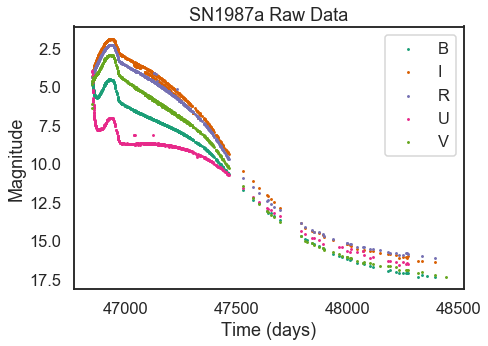

In [3]:

fig = plt.figure(figsize=(7,5))

for i in range(len(band_name)):
    plt.scatter(time[band == band_name[i]], mag[band == band_name[i]], label = str(band_name[i]), s = 2.)
    plt.legend()

plt.xlabel(r'Time (days)')
plt.ylabel('Magnitude')
plt.title('SN1987a Raw Data')
plt.gca().invert_yaxis()
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('Charmi_raw_data.png')


In [4]:
mask = (time>46800) & (time < 47200) #focus on the supernovate itself and not the rest of the process
mtab = tab[mask] #masked table
mtime = mtab['time']
mmag = mtab['magnitude']
mband = mtab['band']
min_time = np.min(mtime)
mtime = mtime - min_time # to make time start from zero

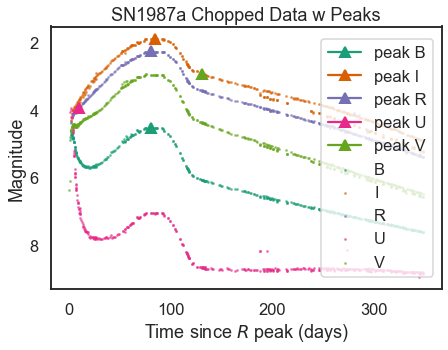

In [5]:
fig = plt.figure(figsize=(7,5))
for i in range(len(band_name)):
    plt.scatter(mtime[mband == band_name[i]], mmag[mband == band_name[i]], label = str(band_name[i]), alpha = 0.5, s= 2)
    #min_index = np.argmin(mmag[mband == band_name[i]])
    min_mag = np.min(mmag[mband == band_name[i]])
    plt.plot(np.median(mtime[mmag == min_mag]), min_mag , marker ='^', label = 'peak ' + str(band_name[i]), ms=10.,  mew=2)
    plt.legend(loc="right")

plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.title('SN1987a Chopped Data w Peaks')
plt.gca().invert_yaxis()
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('Charmi_masked_data.png')



## Mean Model 

In [6]:
class mean_model(Model):
    '''Reurns mean magnitude
        uses a quadratic-quadratic model '''
    parameter_names = ("a1", "b1", "c1","a2", "b2", "c2" )
    
    def get_value(self, t):
        magnitude = []
        for x in t:
            if x < 115: #115 is where the data goes from quadratic to linear (from graph)
                magnitude.append(self.a1*x**2 + self.b1*x + self.c1)
            else:
                magnitude.append(self.a2*x**2 + self.b2*x + self.c2)
        return np.array(magnitude)

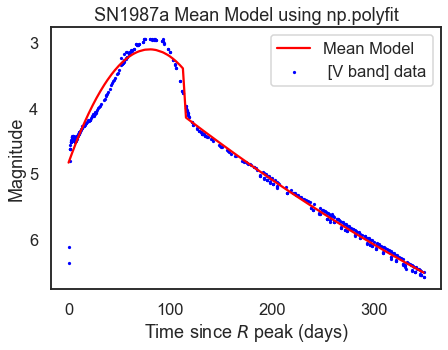

In [7]:
#getting all the data needed to plot V band
v_mtime = np.asarray(mtime[mband == 'V'])
v_mmag =  np.asarray(mmag[mband == 'V'])
A1,B1,C1 = np.polyfit(v_mtime[v_mtime<115], v_mmag[v_mtime<115], 2)
A2,B2,C2  = np.polyfit(v_mtime[v_mtime>115], v_mmag[v_mtime>115], 2)
model_flux = mean_model(a1=A1, b1= B1, c1=C1, a2=A2, b2=B2, c2=C2).get_value(v_mtime)

#plot the model on top of the original data  
fig = plt.figure(figsize=(7,5))
plt.scatter(v_mtime, v_mmag, label = " [V band] data", s = 3, color = 'Blue')
plt.plot(v_mtime, model_flux,'b-', label = "Mean Model", color = "red")
plt.legend()
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.title('SN1987a Mean Model using np.polyfit')
plt.gca().invert_yaxis() 
plt.gcf().subplots_adjust(bottom=0.15) 
plt.savefig('Charmi_mean_model.png') 
plt.show()


## GP Model

[ 2.71116252e-04 -4.31769322e-02  4.83143624e+00 -7.30072808e-06
  1.34684156e-02  2.69319695e+00  4.38202663e+00]


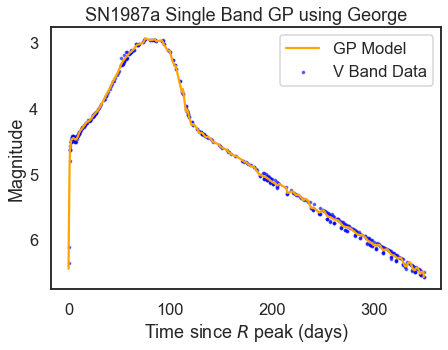

In [8]:
#GP model for V band
MEAN = mean_model(a1=A1, b1= B1, c1=C1, a2=A2, b2=B2, c2=C2)
k = kernels.ExpSquaredKernel(80.0)

gp = george.GP(k, mean = MEAN)
gp.compute(v_mtime)

print(gp.get_parameter_vector())

mu,var = gp.predict(v_mmag,v_mtime,return_var=True)


fig = plt.figure(figsize=(7,5))
plt.scatter(v_mtime, v_mmag, label = "V Band Data", alpha = 0.5, s = 5, color = 'blue')
#plt.plot(v_mtime, model_flux,'b-', label = "Mean Model")
plt.plot(v_mtime, mu, color="orange", label = 'GP Model ')
plt.legend()
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.title('SN1987a Single Band GP using George')
plt.gca().invert_yaxis() 
plt.gcf().subplots_adjust(bottom=0.15) 
plt.savefig('Charmi_GP_model(Singleband).png') 
plt.show()

## GP using pymc3

In [9]:
#The mean function is the same as before but its rewritten in a format that is acceptable by the gp.marginal function
import theano.tensor as tt
import pymc3 as pm

class MeanModel(pm.gp.mean.Mean):

    def __init__(self, a1,b1,c1,a2,b2,c2):
        self.a1 = a1
        self.b1 = b1
        self.c1 = c1
        self.a2 = a2
        self.b2 = b2
        self.c2 = c2
        
    def __call__(self, t):
        t = np.array(t)
        peak_t = 115
        rise_t = t[t <= peak_t]
        fall_t = t[t > peak_t]
        rise_mag = self.a1*rise_t**2 + self.b1*rise_t + self.c1
        fall_mag = self.a1*fall_t**2 + self.b1*fall_t + self.c1
        mean_mag = tt.concatenate([rise_mag, fall_mag])
        return mean_mag


In [10]:
X =v_mtime[:,None] #Change from row to column vector 
Y = v_mmag #stays row vector


In [11]:
with pm.Model() as marginal_gp_model:
    # Specify the covariance function.
    l = pm.HalfNormal('l', sigma=20)
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=l)
    #cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=50)
    
    aa1 = pm.Normal('aa1', mu=A1, sigma=A1*1e-1, shape=1)
    bb1 = pm.Normal('bb1', mu=B1, sigma=B1*1e-1, shape=1)
    cc1 = pm.Normal('cc1', mu=C1, sigma=C1*1e-1, shape=1)
    aa2 = pm.Normal('aa2', mu=A2, sigma=A2*1e-1, shape=1)
    bb2 = pm.Normal('bb2', mu=B2, sigma=B2*1e-1, shape=1)
    cc2 = pm.Normal('cc2', mu=C2, sigma=C2*1e-1, shape=1)
    
    
    # Specify the GP
    MEAN = MeanModel(a1=aa1, b1= bb1, c1=cc1, a2=aa2, b2=bb2, c2=cc2)
    gp = pm.gp.Marginal(cov_func=cov_func, mean_func = MEAN)

    # The scale of the white noise term can be provided,
    #sigma = pm.HalfCauchy("sigma", beta=0.75)
    y_ = gp.marginal_likelihood("y", X=X, y=Y, noise=0.1)
    MAP =  pm.find_MAP()

/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use

In [12]:
X_new = np.linspace(0, np.max(X),len(X))[:,None]

# add the GP conditional to the model, given the new X values
with marginal_gp_model:
    f_pred = gp.conditional("f_pred", X_new)

#To use the MAP values, you can just replace the trace with a length-1 list with `mp`

with marginal_gp_model:
    pred_samples = pm.sample_posterior_predictive([MAP], vars=[f_pred],samples=50)

/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|          | 0/50 [00:00<?, ?it/s]/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is 

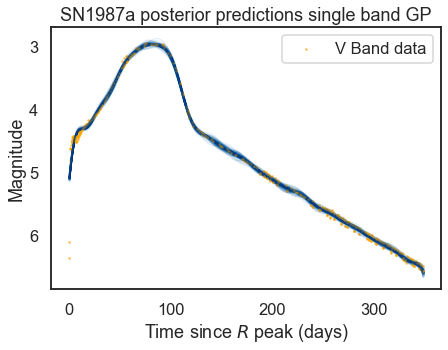

In [13]:
from pymc3.gp.util import plot_gp_dist
# plot the results
fig = plt.figure(figsize=(7,5))
ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new, palette = 'Blues')
plt.scatter(v_mtime, v_mmag,s =1, label = "V Band data",alpha = 0.7, color = "orange")
plt.legend(loc='best')
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.title('SN1987a posterior predictions single band GP')
plt.gca().invert_yaxis() 
plt.gcf().subplots_adjust(bottom=0.15) 
plt.savefig('charmi_pymc3(singleband).png') 
plt.show()

## Hierarchical model using pymc3

In [14]:
#create dictionary for all band data including time, mag, mean params, X(column vector)
d = {} 
for i in band_name:
    d[i+'_mtime'] = np.asarray(mtime[mband == i])
    d[i+'_mmag'] =  np.asarray(mmag[mband == i])
    A1,B1,C1 = np.polyfit(d[i+'_mtime'][d[i+'_mtime']<115], d[i+'_mmag'][d[i+'_mtime']<115], 2)
    A2,B2,C2 = np.polyfit(d[i+'_mtime'][d[i+'_mtime']<115], d[i+'_mmag'][d[i+'_mtime']<115], 2)
    d[i+'_params'] = np.array([A1,B1,C1,A2,B2,C2])
    d[i+'_X'] = d[i+'_mtime'][:,None]
    

/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/Users/charmipatel/anaconda3/envs/fds/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use

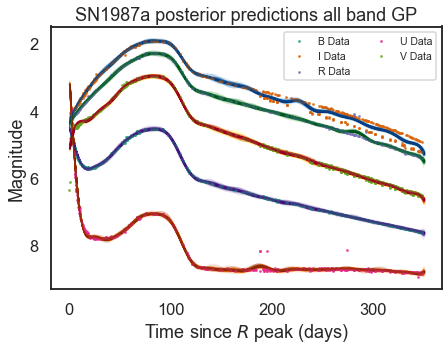

In [15]:
fig = plt.figure(figsize=(7,5))
ax = fig.gca()
cmap = ['Purples', 'Blues', 'Greens', 'Oranges', 'YlOrRd']
color = ["violet", 'lightblue', "teal",'orange', 'red']
X_new = np.linspace(0, 350,200)[:,None]

for x in range(len(band_name)):
    i = band_name[x]
    with pm.Model() as hierarchical_model: 
        l = pm.HalfNormal('l', sigma=20)
        cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=l)

        p = d[i+'_params']
        A1,B1,C1,A2,B2,C2 = p[0],p[1],p[2],p[3],p[4],p[5]
        aa1 = pm.Normal('aa1', mu=A1, sigma=A1*1e-1, shape=1)
        bb1 = pm.Normal('bb1', mu=B1, sigma=B1*1e-1, shape=1)
        cc1 = pm.Normal('cc1', mu=C1, sigma=C1*1e-1, shape=1)
        aa2 = pm.Normal('aa2', mu=A2, sigma=A2*1e-1, shape=1)
        bb2 = pm.Normal('bb2', mu=B2, sigma=B2*1e-1, shape=1)
        cc2 = pm.Normal('cc2', mu=C2, sigma=C2*1e-1, shape=1)


        MEAN = MeanModel(a1=aa1, b1= bb1, c1=cc1, a2=aa2, b2=bb2, c2=cc2)
        gp = pm.gp.Marginal(cov_func=cov_func, mean_func = MEAN)
        y_ = gp.marginal_likelihood("y", X=d[i+'_X'], y=d[i+'_mmag'], noise=0.1)
        MAP =  pm.find_MAP()
        
    with marginal_gp_model:
        d[i+'_fpred'] = gp.conditional(i+'_fpred', X_new)

    with marginal_gp_model:
        d[i+'_pred_samples'] = pm.sample_posterior_predictive([MAP], vars=[d[i+'_fpred']],samples=50)
    
    plot_gp_dist(ax, d[i+'_pred_samples'][i+'_fpred'], X_new, palette = cmap[x])
    plt.scatter(d[i+'_mtime'], d[i+'_mmag'] ,s =2, label = i+" Data",alpha = 0.7, cmap = color[x])



plt.legend(loc='upper right', ncol =2, fontsize = 'xx-small')
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.title('SN1987a posterior predictions all band GP')
plt.gca().invert_yaxis() 
plt.gcf().subplots_adjust(bottom=0.15) 
plt.savefig('charmi_pymc3(allband).png') 
plt.show()

## median posterior prediction

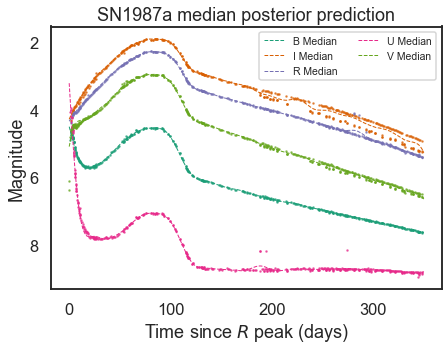

In [16]:
fig = plt.figure(figsize=(7,5))
ax = fig.gca()
X_new = np.linspace(0, 350,200)

for x in range(len(band_name)):
    i = band_name[x]
    d[i+"_med"] = np.median(d[i+'_pred_samples'][i+'_fpred'], axis=0)
    d[i+'_std'] = np.std(d[i+'_pred_samples'][i+'_fpred'], axis=0)
    plt.plot(X_new, d[i+"_med"], ls = '--', linewidth= 1 ,label = i+" Median")
    plt.scatter(d[i+'_mtime'], d[i+'_mmag'] ,s =1,alpha = 0.7)

plt.title('SN1987a median posterior prediction')
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right',ncol =2, fontsize = 'xx-small' )
plt.gca().invert_yaxis()
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('charmi_median_sample.png')
plt.show()

## flux, luminosity, and temperature

In [24]:
def find_error(arr, error):
    return arr * error

def convert_mag_to_flux(mag, fo):
    return fo* 10**(-mag/2.5)

def convert_flux_to_Fbol(X_new, F_L):
    F_bol = []
    for i in range(len(X_new)):
        flux = [(convert_mag_to_flux(d[band_name[n]+"_med"][i],F_L[n])) for n in range(5)]
        F_bol.append(np.trapz(flux,lamda))
    return F_bol

def convert_fbol_to_luminosity(flux, d):
    return 4*np.pi* (d**2) * flux

def convert_luminosity_to_temp(lum,sigma,r):
    return (lum/(4*np.pi*(r**2)*sigma))**(1./4) # Kelvin

In [29]:
# get errors in form [band1, band2, ...], [band1, band2, ...]
mag_err = (np.stack((d['U_std'],d['B_std'],d['V_std'],d['R_std'],d['I_std']))).T
mag_err_allwave = np.array([np.sqrt(err[0]**2 + err[1]**2 + err[2]**2 + err[3]**2 + err[4]**2 ) for err in mag_err ])

#get all other parameters
wavelengths = (np.array([435,  879.7,  634.9,365.6, 547.7])*10) 
lamda = wavelengths[np.argsort(wavelengths)] #in  A˚ 
X_new = np.linspace(0, 350,200)
F_L = (np.array([632,112.6,217.7,417.5, 363.1])*(1e-11))[np.argsort(wavelengths)] #ergs/(cm^2 * s * A˚)
band_name = band_name[np.argsort(wavelengths)]
D = 0.043*3.086e24 #distace to the supernova in cm
R = 6.23e15 #radius of the supernova in m
sigma = 5.6704e-5 #erg⋅cm−2⋅s−1⋅K−4

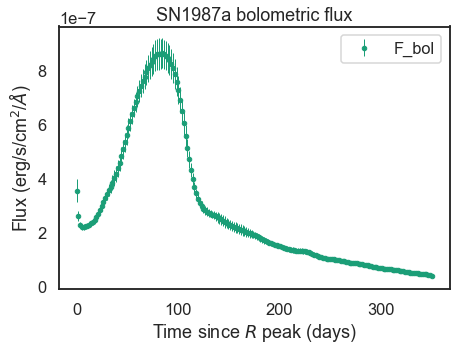

In [30]:
F_bol = convert_flux_to_Fbol(X_new,F_L)
Fbol_err = find_error(F_bol,mag_err_allwave)

fig = plt.figure(figsize=(7,5))
plt.errorbar(x=X_new, y=F_bol, yerr=Fbol_err, elinewidth = 1., label='F_bol', fmt='.') 
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel(r'Flux (erg/s/cm$^2$/$\AA$)')
plt.title('SN1987a bolometric flux')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend()
plt.savefig('Charmi_bolF.png', bbox_inches='tight')


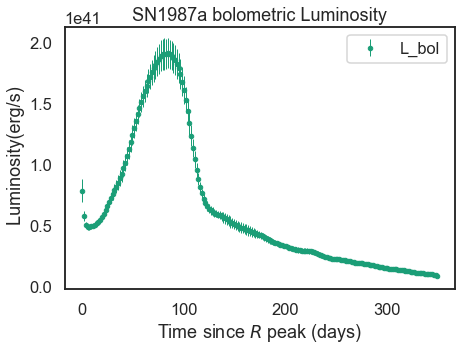

In [31]:
L_bol = convert_fbol_to_luminosity(np.array(F_bol), D)
Lbol_err = find_error(L_bol,mag_err_allwave)

fig = plt.figure(figsize=(7,5))
plt.errorbar(x=X_new, y=L_bol, yerr=Lbol_err, elinewidth = 1., label='L_bol', fmt='.') 
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel(r' Luminosity(erg/s)')
plt.title('SN1987a bolometric Luminosity')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend()
plt.savefig('Charmi_bolL.png', bbox_inches='tight')


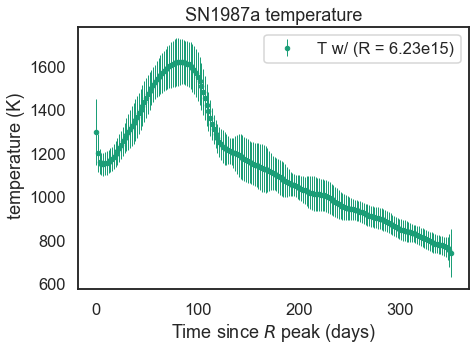

In [32]:
temp = convert_luminosity_to_temp(np.array(L_bol),sigma,R)
temp_err = find_error(temp,mag_err_allwave)

fig = plt.figure(figsize=(7,5))
plt.errorbar(x=X_new, y=temp, yerr=temp_err, elinewidth = 1., label='T w/ (R = 6.23e15)', fmt='.') 
plt.xlabel(r'Time since $R$ peak (days)')
plt.ylabel(r' temperature (K)')
plt.title('SN1987a temperature')
plt.legend()
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('Charmi_temp.png', bbox_inches='tight')
